## Starts here

In [215]:
from model import SimCLR, SimSiam, BYOL

import torchvision, torch
import torch.nn as nn

def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['opt'])
    if scheduler:
        scheduler.load_state_dict(checkpoint['scheduler'])
    return checkpoint['epoch'], checkpoint['best_loss']

resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
 
model_dict = {'simclr': SimCLR, 'byol': BYOL, 'simsiam': SimSiam}
model_name = 'byol'
aug = '_blur_freqPatch'
path = f'../logs/{model_name}{aug}_cifar100/last.pt'

model = model_dict[model_name](backbone).cuda()
e, l = load_checkpoint(model, None, None, path)

/tmp/ipykernel_488283/2395033084.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


KeyError: 'best_loss'

In [ ]:
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []
    model  = model.eval()
    
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs = inputs.cuda()
            features = model.get_embedding(inputs)
            # features = model.backbone(inputs)  
            # features = model.proj_head(features)  
            # features = F.normalize(features, dim=1) 
            embeddings.append(features.cpu())
            labels.append(targets)
    
    return torch.cat(embeddings), torch.cat(labels)



In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-10 train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

In [216]:
train_embeddings, train_labels = extract_embeddings(trainloader, model)
test_embeddings, test_labels = extract_embeddings(testloader, model)

In [217]:
import torch.optim as optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

mlp = MLP(input_dim=512, hidden_dim=512, output_dim=10) 
mlp = mlp.cuda()


optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()



In [218]:
import torchmetrics
from sklearn.metrics import classification_report

def train_mlp(mlp, optimizer, criterion, train_embeddings, train_labels, 
              test_embeddings, test_labels, epochs=10):


    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).cuda()
    precision_metric = torchmetrics.Precision(task="multiclass",num_classes=10, average='macro').cuda()
    recall_metric = torchmetrics.Recall(task="multiclass",num_classes=10, average='macro').cuda()
    f1_metric = torchmetrics.F1Score(task="multiclass",num_classes=10, average='macro').cuda()

        # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(epochs):
        # Training Phase
        mlp.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(train_embeddings.cuda())
        loss = criterion(outputs, train_labels.cuda())
        loss.backward()
        optimizer.step()

        # Compute metrics
        preds = torch.argmax(outputs, dim=1)
        accuracy = accuracy_metric(preds, train_labels.cuda())
        precision = precision_metric(preds, train_labels.cuda())
        recall = recall_metric(preds, train_labels.cuda())
        f1 = f1_metric(preds, train_labels.cuda())

        # Store the metrics and loss
        train_losses.append(loss.item())
        train_accuracies.append(accuracy.item())
        train_precisions.append(precision.item())
        train_recalls.append(recall.item())
        train_f1_scores.append(f1.item())

        # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, '
        #       f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
        #       f'Recall: {recall:.4f}, F1-score: {f1:.4f}')

        # Validation Phase
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(test_embeddings.cuda())
            val_loss = criterion(val_outputs, test_labels.cuda())
            val_preds = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_metric(val_preds, test_labels.cuda())
            val_precision = precision_metric(val_preds, test_labels.cuda())
            val_recall = recall_metric(val_preds, test_labels.cuda())
            val_f1 = f1_metric(val_preds, test_labels.cuda())

            # Store the validation metrics
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy.item())
            val_precisions.append(val_precision.item())# sion: {val_precision:.4f}, '
            #       f'Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}')

        # Reset metrics for the next epoch
        accuracy_metric.reset()
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()

    return (train_losses, train_accuracies, train_precisions, train_recalls, train_f1_scores, \
           val_losses,val_accuracies, val_precisions, val_recalls, val_f1_scores), mlp


def knn_eval(train_embeddings, train_labels, 
              test_embeddings, test_labels):
    
    from utilz.knn import knn
    # knn(test_embeddings, train_embeddings, train_labels)

    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).cuda()
    precision_metric = torchmetrics.Precision(task="multiclass",num_classes=10, average='macro').cuda()
    recall_metric = torchmetrics.Recall(task="multiclass",num_classes=10, average='macro').cuda()
    f1_metric = torchmetrics.F1Score(task="multiclass",num_classes=10, average='macro').cuda()

    val_losses,val_accuracies, val_precisions, val_recalls, val_f1_scores = tuple([[] for i in range(5)])

    val_outputs = knn(test_embeddings.cuda(), train_embeddings.cuda(), train_labels.cuda(), K = 20)
    val_loss = criterion(val_outputs, test_labels.cuda())
    val_preds = torch.argmax(val_outputs, dim=1)
    val_accuracy = accuracy_metric(val_preds, test_labels.cuda())
    val_precision = precision_metric(val_preds, test_labels.cuda())
    val_recall = recall_metric(val_preds, test_labels.cuda())
    val_f1 = f1_metric(val_preds, test_labels.cuda())

    # Store the validation metrics
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())
    val_precisions.append(val_precision.item())
    val_recalls.append(val_recall.item())
    val_f1_scores.append(val_f1.item())

    return val_losses,val_accuracies, val_precisions, val_recalls, val_f1_scores    

In [223]:
# metrics = knn_eval(train_embeddings[:20000], train_labels[:20000], test_embeddings, test_labels)
metrics, mlp = train_mlp(mlp, optimizer, criterion, train_embeddings[:20000], train_labels[:20000],test_embeddings, test_labels, epochs=500)

In [224]:
# metrics

In [225]:
train_labels[:20000].unique(return_counts = True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1988, 2031, 2067, 1992, 1985, 1920, 1970, 1988, 1984, 2075]))

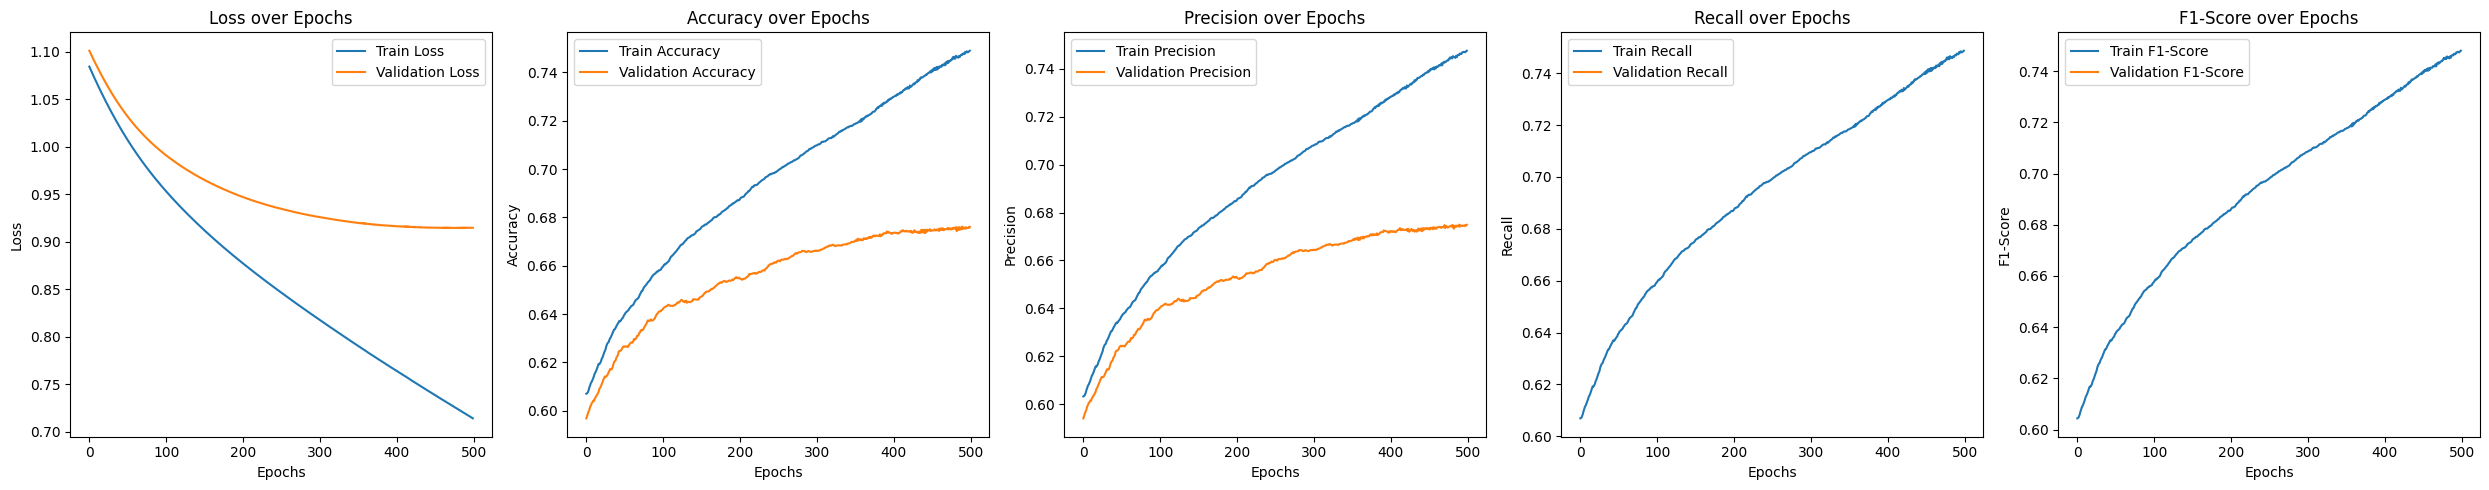

In [226]:
import matplotlib.pyplot as plt
# Train the model and retrieve the metrics
train_losses, train_accuracies, train_precisions, train_recalls, train_f1_scores, \
val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores = metrics

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend()

# Plot Accuracy
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].legend()

# Plot Precision
axes[2].plot(train_precisions, label='Train Precision')
axes[2].plot(val_precisions, label='Validation Precision')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision over Epochs')
axes[2].legend()

# Plot Recall
axes[3].plot(train_recalls, label='Train Recall')
axes[3].plot(val_recalls, label='Validation Recall')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Recall')
axes[3].set_title('Recall over Epochs')
axes[3].legend()

# Plot F1-Score
axes[4].plot(train_f1_scores, label='Train F1-Score')
axes[4].plot(val_f1_scores, label='Validation F1-Score')
axes[4].set_xlabel('Epochs')
axes[4].set_ylabel('F1-Score')
axes[4].set_title('F1-Score over Epochs')
axes[4].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



In [227]:
# #('/home/dhruva/CTRL/pshakti_saves/mlp.pth')
# save_path = 'mlps/'
# mlp.eval()
# mlp_path = save_path+model_name + aug +'_mlp.pth'
# # torch.save(mlp.state_dict(), '/home/dhruva/CTRL/pshakti_saves/mlp.pth')
# torch.save(mlp.state_dict(), mlp_path)

In [208]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

class CombinedModel(nn.Module):
    def __init__(self, model, pretrained_mlp):
        super(CombinedModel, self).__init__()
        self.model = model
        self.pretrained_mlp = pretrained_mlp
        self.tform = transforms.Normalize(mean, std)

    # def train(self, mode=True):
    #     self.backbone.train(mode)
    #     self.pretrained_mlp.train(mode)

    def forward(self, x):
        # x = self.tform(x)
        # Get projection head output from the SimCLR model
        projections = self.model.get_embedding(x)
        # print(projections.shape)
        
        # Pass the projections through the pretrained MLP
        mlp_output = self.pretrained_mlp(projections)
        
        return mlp_output



     

In [209]:
# mlp = MLP(input_dim=512, hidden_dim=512, output_dim=10)
# mlp.load_state_dict(torch.load(mlp_path))
# mlp = mlp.cuda()
combined_model = CombinedModel(model, mlp)   
combined_model = combined_model.cuda()
_ = combined_model.eval()

In [210]:
# from robustbench.data import load_cifar10

# x_test, y_test = load_cifar10(n_examples=50)

# ### Normalize x_test according to cifar10 normalization
# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
# std =  torch.tensor([0.2471, 0.2435, 0.2616]).view(1, 3, 1, 1)
# # max_x = x_test.max()
# # min_x = x_test.min()
# # x_test = (x_test - min_x) / (max_x - min_x)
# x_test = (x_test - mean) / std

In [211]:
# import foolbox as fb
# fmodel = fb.PyTorchModel(model, bounds=(0,1))

# _, advs, success = fb.attacks.LinfPGD()(fmodel, x_test.to('cuda:0'), y_test.to('cuda:0'), epsilons=[8/255])
# print('Robust accuracy: {:.1%}'.format(1 - success.float().mean()))

In [212]:
# import torch

# from robustbench import benchmark


# threat_model = "Linf"  # one of {"Linf", "L2", "corruptions"}
# dataset = "cifar10"  # one of {"cifar10", "cifar100", "imagenet"}

# model_name = 'olala'
# device = torch.device("cuda:0")

# clean_acc, robust_acc = benchmark(combined_model.train(), model_name=model_name, n_examples=1000, dataset=dataset,
#                                   threat_model=threat_model, eps=8/255, device=device,
#                                   to_disk=True,preprocessing=transform_train)

#### https://github.com/GodXuxilie/RobustSSL_Benchmark/blob/main/Finetuning_Methods/Vanilla_Finetuning/utils.py RUNAA FUNCTION FROM HERE


In [213]:
from autoattack import AutoAttack

def runAA(model, test_loader, log_path, advFlag=None):
    model.eval()
    acc = 0.
    # test_loader.batch_size = 8000 if args.dataset == 'stl10' else 10000
    test_loader = torch.utils.data.DataLoader(
        test_loader.dataset, batch_size= 10000, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
    adversary = AutoAttack(model, norm='Linf', eps=2/255, version='standard', log_path=log_path)
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        xadv = adversary.run_standard_evaluation(images, labels, bs=1000)
        with torch.no_grad():
            if advFlag is not None:
                output = model.eval()(xadv, advFlag)
            else:
                output = model.eval()(xadv)
        acc += (output.max(1)[1] == labels).float().sum()
    return acc.item() 

In [214]:
runAA(combined_model.eval(), testloader, log_path='logs/aa', advFlag=None)

setting parameters for standard version


using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 80.40%
apgd-ce - 1/9 - 502 out of 1000 successfully perturbed
apgd-ce - 2/9 - 464 out of 1000 successfully perturbed
apgd-ce - 3/9 - 438 out of 1000 successfully perturbed
apgd-ce - 4/9 - 443 out of 1000 successfully perturbed
apgd-ce - 5/9 - 465 out of 1000 successfully perturbed
apgd-ce - 6/9 - 463 out of 1000 successfully perturbed
apgd-ce - 7/9 - 472 out of 1000 successfully perturbed
apgd-ce - 8/9 - 461 out of 1000 successfully perturbed
apgd-ce - 9/9 - 15 out of 40 successfully perturbed
robust accuracy after APGD-CE: 43.17% (total time 9.8 s)
apgd-t - 1/5 - 6 out of 1000 successfully perturbed
apgd-t - 2/5 - 3 out of 1000 successfully perturbed
apgd-t - 3/5 - 10 out of 1000 successfully perturbed
apgd-t - 4/5 - 7 out of 1000 successfully perturbed
apgd-t - 5/5 - 0 out of 317 successfully perturbed
robust accuracy after APGD-T: 42.91% (total time 76.2 s)
fab-t - 1/5 - 0 out of 1000 successfully per

4293.0

In [ ]:
# # autoattack is installed as a dependency of robustbench so there is not need to install it separately
# from autoattack import AutoAttack
# adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'])
# adversary.apgd.n_restarts = 1
# x_adv = adversary.run_standard_evaluation(x_test, y_test)

In [19]:
clean_acc, robust_acc

(0.816, 0.261)